In [3]:
from collections import deque
from imutils.video import VideoStream
import numpy as np
import cv2 
import imutils
import time
import pandas as pd



Trackeo en base a un video, guardando los datos en un position.csv. ETA: 30s

In [4]:
import cv2
import imutils

# Definir el color a trackear en el espacio HSV
greenLower = (60, 55, 90)
greenUpper = (85, 240, 270)

# Crear un DataFrame para almacenar las posiciones y tiempos
position_df = pd.DataFrame()

# Abrir el video
vs = cv2.VideoCapture('VideoCL.mp4')

# Obtener el alto del frame (para ajustar el eje de coordenadas) y el framerate
_, frame = vs.read()
frame_height = frame.shape[0]
fps = vs.get(cv2.CAP_PROP_FPS)

# Calcular el tiempo real por cuadro en la vida real (cada segundo de video son 8 segundos en la vida real)
time_per_frame_real = 1 / (fps * 8)

# Inicializar contador de cuadros
frame_count = 0

# Loop que recorre el video cuadro a cuadro
while True:
    # Leer el siguiente cuadro
    _, frame = vs.read()

    # Si no hay más cuadros, romper el bucle
    if frame is None:
        break

    # Redimensionar el cuadro y aplicarle un desenfoque gaussiano
    frame = imutils.resize(frame, width=600)
    blurred = cv2.GaussianBlur(frame, (11, 11), 0)
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)

    # Crear la máscara para el rango de colores
    mask = cv2.inRange(hsv, greenLower, greenUpper)
    mask = cv2.erode(mask, None, iterations=2)
    mask = cv2.dilate(mask, None, iterations=2)

    # Encontrar contornos y determinar el centroide
    cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    center = None

   
    # Continuar si se encontraron contornos
    if len(cnts) > 0:
        c = max(cnts, key=cv2.contourArea)
        ((x, y), radius) = cv2.minEnclosingCircle(c)
        M = cv2.moments(c)

        # Asegurarse de que M["m00"] no sea cero para evitar errores de división
        if M["m00"] > 0:
            center = (int(M["m10"] / M["m00"]), int(M["m01"] / M["m00"]))

            if radius > 10:
                # Dibujar círculo y centroide en el frame
                cv2.circle(frame, (int(x), int(y)), int(radius), (0, 255, 255), 2)
                cv2.circle(frame, center, 5, (0, 0, 255), -1)

    # Solo guardar posiciones si center no es None
    if center is not None:
        # Cambiar el eje y restando el valor de y al alto del frame
        adjusted_center = (center[0], frame_height - center[1])

        # Calcular el tiempo real transcurrido
        time_real = frame_count * time_per_frame_real

        # Guardar la posición y el tiempo en el DataFrame
        position_df = pd.concat([position_df, pd.DataFrame({'x': [adjusted_center[0]], 'y': [adjusted_center[1]], 'time_real': [time_real]})], ignore_index=True)

    # Mostrar los cuadros
    cv2.imshow('Frame', frame)
    cv2.imshow('Mask', mask)

    # Incrementar contador de cuadros
    frame_count += 1

    key = cv2.waitKey(1) & 0xFF
    if key == ord("q"):
        break

# Liberar el video y cerrar las ventanas
vs.release()
cv2.destroyAllWindows()

# Guardar las posiciones y tiempos en un archivo CSV
position_df.to_csv('position.csv', index=False)



Pasaje de unidades y generación de gráficos.

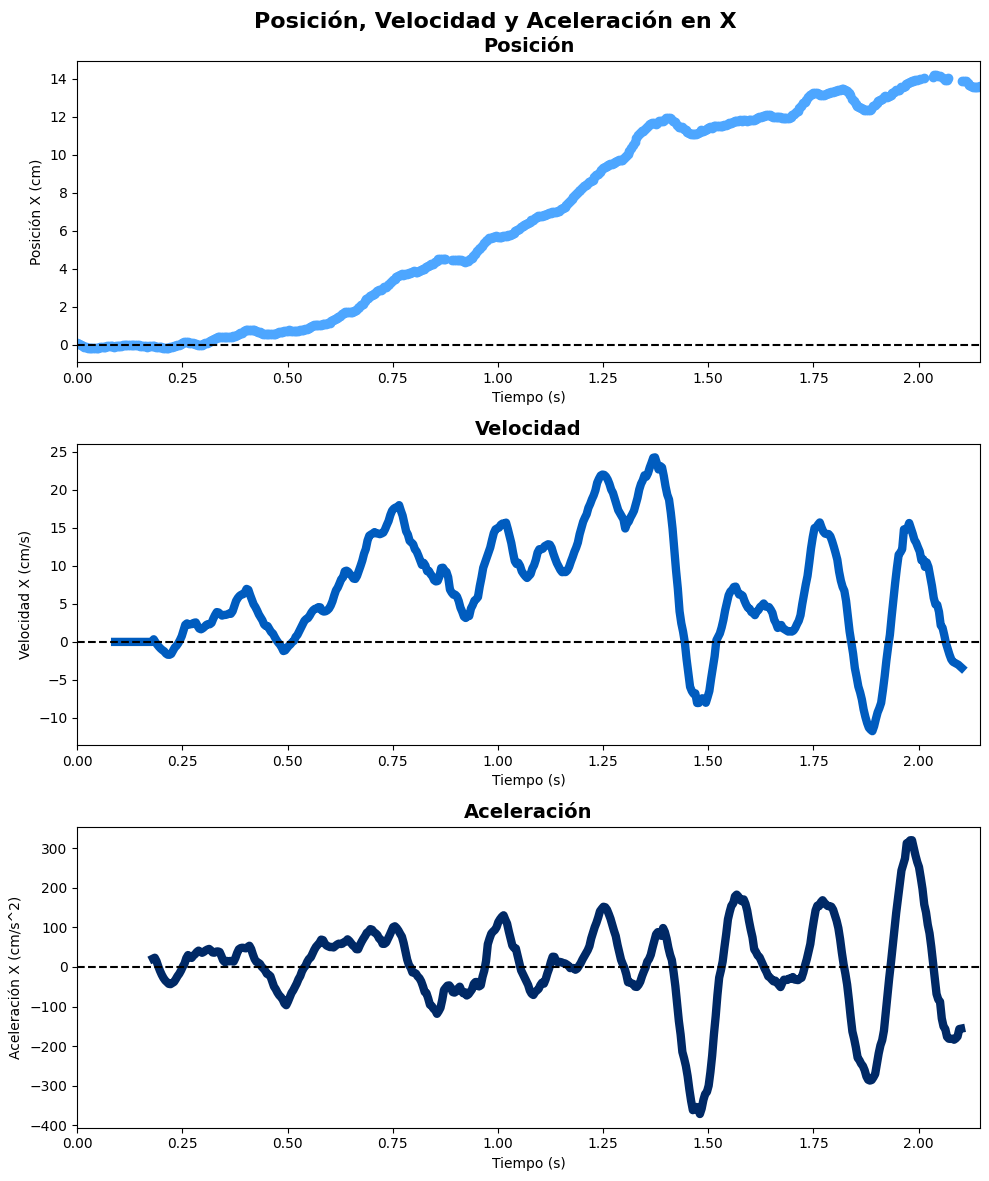

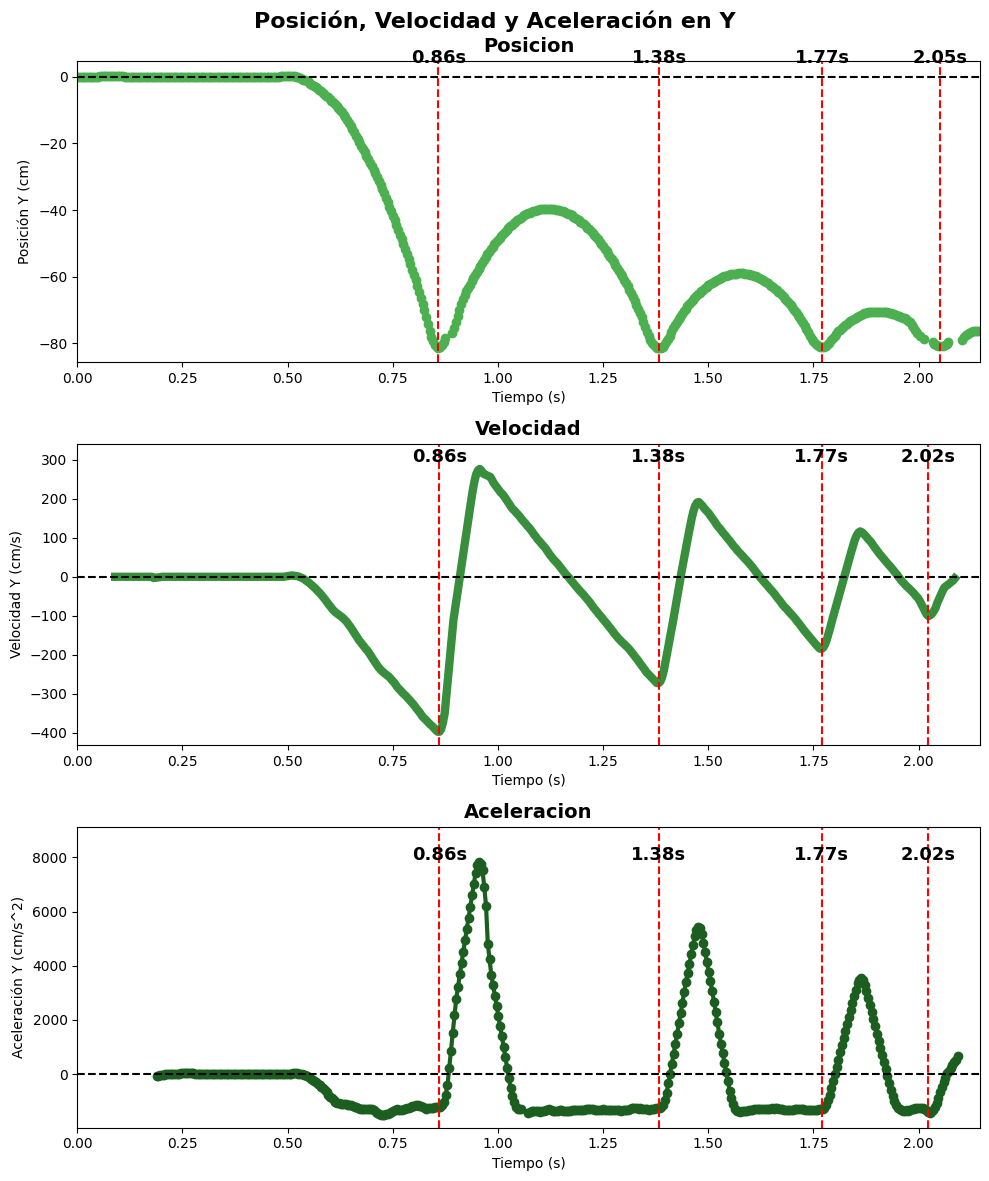

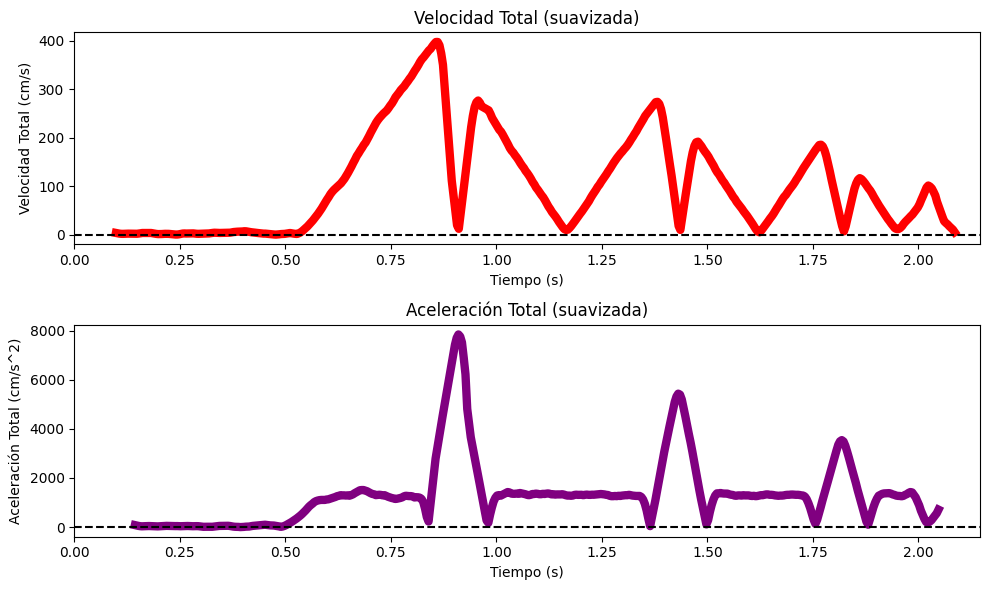

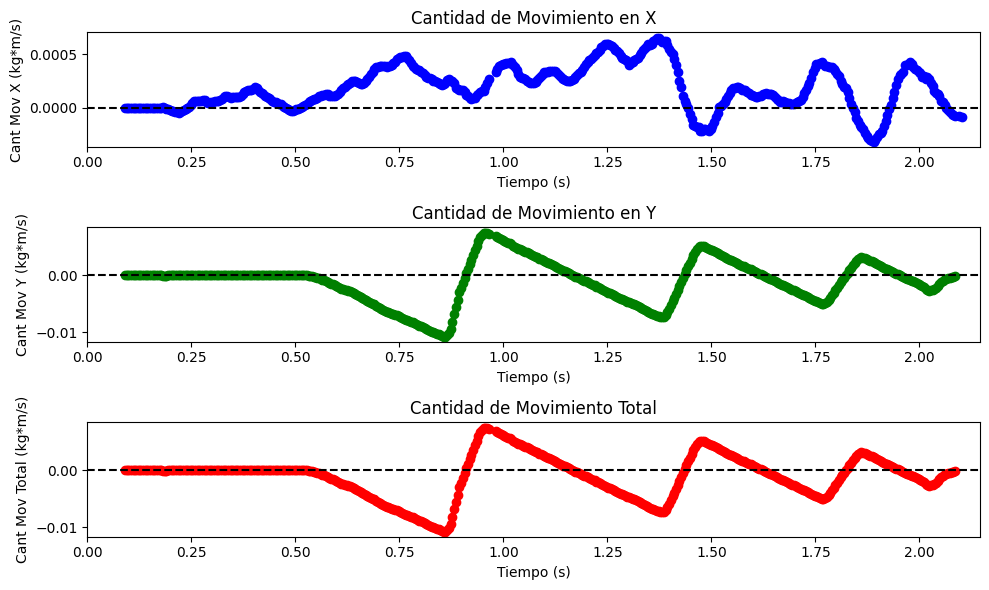

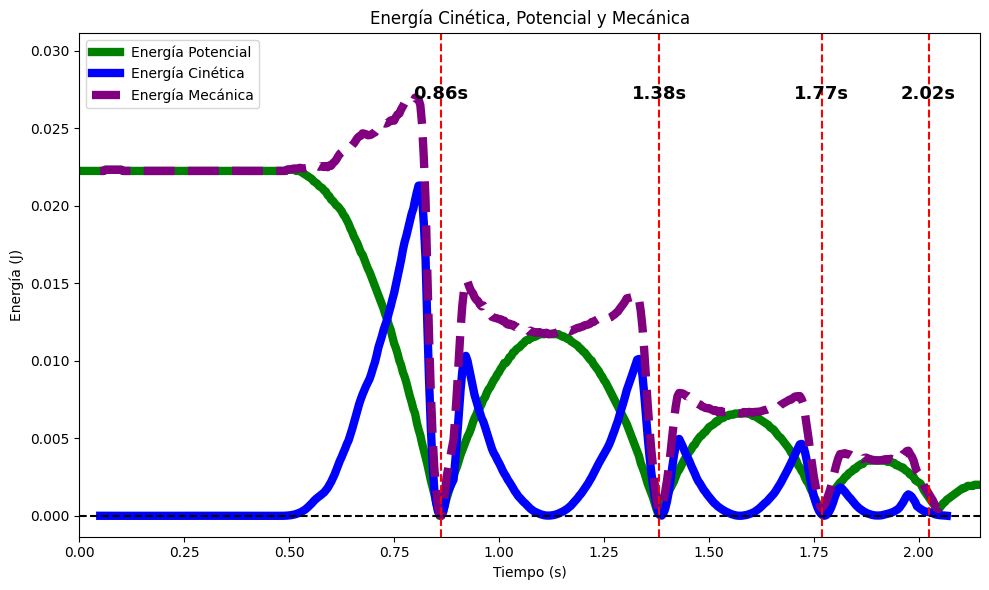

Parametros:
 [-654.05788975  650.25473982 -161.36117617]
Matriz de Covarianza:
 [[ 10.45465492 -13.59105137   4.33650376]
 [-13.59105137  17.73280083  -5.67933703]
 [  4.33650376  -5.67933703   1.82646571]]


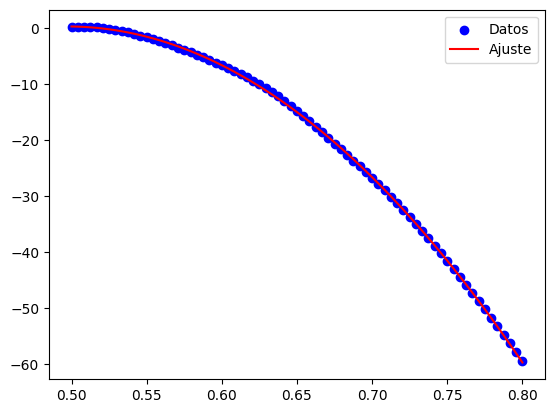

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
import scipy.signal 
from scipy.optimize import curve_fit


# Leer los datos desde position.csv
df = pd.read_csv('position.csv')

#RELACION PIXEL-METRO.
#Las cajas miden 230 pixeles en el video, y sabemos que mide 64.8cm. Con estos datos calculamos.
pixel_to_cm = 0.28
# Definir el tamaño del filtro de media móvil para suavizado
SUAVIZADO = -20 
window_size = 5
window_length_pos = 21
polyorder_pos = 2

# Suavizar las posiciones usando un filtro de media móvil
df["x_smooth"] = df["x"]
df["y_smooth"] = df["y"]
df['x_smooth'] = savgol_filter(df['x'], window_length=window_length_pos, polyorder=polyorder_pos, mode="nearest")
df['y_smooth'] = savgol_filter(df['y'], window_length=window_length_pos, polyorder=polyorder_pos, mode="nearest")

#Convertir posiciones de pixeles a cm
init_x = df.iloc[2]['x_smooth']
init_y = df.iloc[2]['y_smooth']
df['x_smooth_cm'] = (df['x_smooth'] - init_x) * pixel_to_cm
df['y_smooth_cm'] = (df['y_smooth']- init_y) * pixel_to_cm
df['x_cm'] = (df['x'] - init_x) * pixel_to_cm
df['y_cm'] = (df['y'] - init_y) * pixel_to_cm

# Calcular el delta de tiempo (saltando un punto)
df['delta_time'] = df['time_real'].shift(SUAVIZADO) - df['time_real']

# Calcular las velocidades como la diferencia de posiciones dividida por el intervalo de tiempo
# Usar x3 - x1 y y3 - y1 para calcular velocidades
df['vx'] = (df['x_smooth_cm'].shift(SUAVIZADO) - df['x_smooth_cm']) / df['delta_time']
df['vy_raw'] = (df['y_cm'].shift(SUAVIZADO) - df['y_cm']) / df['delta_time']

window_size_vel = 5
# Aplicar un filtro de media móvil a las velocidades
#df['vx'] = df['vx_raw'].rolling(window=window_size_vel, center=True).mean()
df['vy'] = df['vy_raw'].rolling(window=window_size_vel, center=True).mean()

# Calcular la aceleración como la diferencia de velocidades dividida por el intervalo de tiempo
# Usar v3 - v1 y alinearla con el tiempo intermedio
df['ax'] = (df['vx'].shift(SUAVIZADO) - df['vx']) / (df['delta_time'])
df['ay'] = (df['vy'].shift(SUAVIZADO) - df['vy']) / (df['delta_time'])

# Calcular la velocidad total (magnitud)
df['v_total'] = np.sqrt(df['vx']**2 + df['vy']**2)

# Calcular la aceleración total (magnitud)
df['a_total'] = np.sqrt(df['ax']**2 + df['ay']**2)


# CANTIDAD DE MOVIMIENTO
masa_pelota = 0.0027  # en kg
df['px'] = masa_pelota * (df['vx'] / 100) #Porque df['vx'] tiene los valores en en cm/s  
df['py'] = masa_pelota * (df['vy'] / 100) #Porque df['vy'] tiene los valores en en cm/s  
df['p_total'] = masa_pelota * (df['v_total'] / 100) # ya que v_total es la magnitud de la velocidad, el 100 porque esta en cm/s


# Guardar los datos en un nuevo archivo CSV
df[['time_real', 'x_cm', 'y_cm', 'vx', 'vy', 'ax', 'ay', 'v_total', 'a_total', 'px', 'py', 'p_total']].to_csv('processed_data.csv', index=False)

# Obtener los límites del tiempo
time_min = df['time_real'].min()
time_max = df['time_real'].max()

#MINIMOS LOCALES POSICION
# Detectar los índices de los mínimos locales para la velocidad Y
minimos_indices_y = scipy.signal.argrelextrema(df['y_smooth_cm'].values, np.less)[0]

# Filtrar los mínimos donde la posicion Y sea menor a -20
minimos_indices_y_filtrados = [
    i for i in minimos_indices_y if df['y_smooth_cm'].values[i] < -20 and  df['time_real'].values[i] != 1.9
]
minimos_tiempos_y_filtrados = df['time_real'].values[minimos_indices_y_filtrados]

#MINIMOS LOCALES VELOCIDAD
# Detectar los índices de los mínimos locales para la velocidad Y
minimos_indices_vy = scipy.signal.argrelextrema(df['vy'].values, np.less)[0]

# Filtrar los mínimos donde la velocidad Y sea menor a -20
minimos_indices_vy_filtrados = [
    i for i in minimos_indices_vy if df['vy'].values[i] < -20
]
minimos_tiempos_vy_filtrados = df['time_real'].values[minimos_indices_vy_filtrados]


# Desfase temporal en segundos
delay = 0.09

# Gráfico 1: Posición, Velocidad y Aceleración en X en una sola imagen
plt.figure(figsize=(10, 12))
plt.suptitle('Posición, Velocidad y Aceleración en X', fontsize=16, fontweight='bold')
# Posición en X
plt.subplot(3, 1, 1)
plt.scatter(df['time_real'], df['x_smooth_cm'], label='Posición X', color='#4da6ff')
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Posición', fontsize=14, fontweight='bold')  
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición X (cm)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

# Velocidad en X
vel_x_plot = np.where(df['time_real'] <= delay, 0, df['vx'])
plt.subplot(3, 1, 2)
plt.plot(df['time_real'] + delay, vel_x_plot, label='Velocidad X', color='#005cbf', linewidth=6)
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Velocidad', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad X (cm/s)')
plt.xlim([0, time_max]) 

# Aceleración en X
plt.subplot(3, 1, 3)
plt.plot(df['time_real'] + 2*delay, df['ax'], label='Aceleración X', color='#002966', linewidth=6)
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Aceleración', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración X (cm/s^2)')
plt.xlim([0, time_max])  

plt.tight_layout()
plt.show()

# Gráfico 2: Posición, Velocidad y Aceleración en Y en una sola imagen
plt.figure(figsize=(10, 12))
plt.suptitle('Posición, Velocidad y Aceleración en Y', fontsize=16, fontweight='bold')
# Posición en Y
plt.subplot(3, 1, 1)
plt.scatter(df['time_real'], df['y_smooth_cm'], label='Posición Y', color='#4CAF50')
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Posicion', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Posición Y (cm)')
plt.xlim([0, time_max]) 

# Marcar mínimos locales para posición Y
y_max = plt.ylim()[1]
for tiempo_minimo in minimos_tiempos_y_filtrados:
    plt.axvline(x=tiempo_minimo, color='red', linestyle='--', label='Mínimo local < -20')
    plt.text(tiempo_minimo, y_max*0.95, f'{tiempo_minimo:.2f}s', color='black', ha='center', fontsize=13, fontweight='bold')
plt.ylim(top=y_max * 1.1) 

# Velocidad en Y
vel_y_plot = np.where(df['time_real'] <= delay, 0, df['vy'])
plt.subplot(3, 1, 2)
plt.plot(df['time_real'] + delay, vel_y_plot, color='#388E3C', linewidth=6)  # Ajusta el grosor de la línea con linewidth
plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Velocidad', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Y (cm/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0


# Marcar mínimos locales para velocidad Y
y_max = plt.ylim()[1]
for tiempo_minimo in minimos_tiempos_vy_filtrados:
    plt.axvline(x=tiempo_minimo + delay, color='red', linestyle='--', label='Mínimo local < -20')
    plt.text(tiempo_minimo + delay, y_max * 0.95, f'{tiempo_minimo + delay:.2f}s', 
             color='black', ha='center', fontsize=13, fontweight='bold')
plt.ylim(top=y_max * 1.1) 

# Aceleración en Y
plt.subplot(3, 1, 3)
plt.plot(df['time_real'] + 2*delay, df['ay'], "-o", color='#1B5E20', linewidth=3)

plt.axhline(y=0, color='k', linestyle='--') 
plt.title('Aceleracion', fontsize=14, fontweight='bold') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración Y (cm/s^2)')
plt.xlim([0, time_max]) 

# Marcar minimos locales aceleración Y
y_max = plt.ylim()[1]
for tiempo_minimo in minimos_tiempos_vy_filtrados:
    plt.axvline(x=tiempo_minimo + delay, color='red', linestyle='--', label='Mínimo local < -20')
    plt.text(tiempo_minimo + delay, y_max * 0.95, f'{tiempo_minimo + delay:.2f}s', 
             color='black', ha='center', fontsize=13, fontweight='bold')
plt.ylim(top=y_max * 1.1) 

plt.tight_layout()
plt.show()


# Gráfico 4: Velocidad total y Aceleración total en gráficos separados
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(df['time_real'] + delay, df['v_total'], label='Velocidad Total', color='red', linewidth=6)
plt.title('Velocidad Total (suavizada)')
plt.axhline(y=0, color='k', linestyle='--') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad Total (cm/s)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.subplot(2, 1, 2)
plt.plot(df['time_real'] + delay * 1.5, df['a_total'], label='Aceleración Total', color='purple', linewidth=6)
plt.title('Aceleración Total (suavizada)')
plt.axhline(y=0, color='k', linestyle='--') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Aceleración Total (cm/s^2)')
plt.xlim([0, time_max])  # Forzar que el eje X empiece en 0

plt.tight_layout()
plt.show()

# Gráfico 5: Cantidad de Movimiento respecto al tiempo
p_x_plot = np.where(df['time_real'] <= delay, 0, df['px'])

plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.scatter(df['time_real'] + delay, p_x_plot, label='Cant Mov X', color='blue')
plt.title('Cantidad de Movimiento en X')
plt.axhline(y=0, color='k', linestyle='--') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov X (kg*m/s)')
plt.xlim([0, time_max])  

p_y_plot = np.where(df['time_real'] <= delay, 0, df['py'])

plt.subplot(3, 1, 2)
plt.scatter(df['time_real'] + delay, p_y_plot, label='Cant Mov Y', color='green')
plt.title('Cantidad de Movimiento en Y')
plt.axhline(y=0, color='k', linestyle='--') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov Y (kg*m/s)')
plt.xlim([0, time_max])  


p_total_plot = np.where(df['time_real'] <= delay, 0, df['py'])
plt.subplot(3, 1, 3)
plt.scatter(df['time_real'] + delay, p_total_plot, label='Cant Mov Total', color='red')
plt.title('Cantidad de Movimiento Total')
plt.axhline(y=0, color='k', linestyle='--') 
plt.xlabel('Tiempo (s)')
plt.ylabel('Cant Mov Total (kg*m/s)')
plt.xlim([0, time_max])  

plt.tight_layout()
plt.show()

#ENERGIA
# Calcular la altura ajustada
altura_minima = df['y_cm'].min()
df['altura_ajustada'] = (df['y_cm'] - altura_minima) / 100

# Calcular energía potencial
df['energia_potencial'] = masa_pelota * 9.81 * (df['altura_ajustada'])  # Convertir altura ajustada a m

# Calcular la energía cinética 
df['energia_cinetica'] = 0.5 * masa_pelota * (df['v_total'].shift(10) / 100)**2  # Convertir v_total a m/s

# Calcular la energía total como la suma de ambas
df['energia_mecanica'] = df['energia_potencial'] + df['energia_cinetica']

#Gráfico
plt.figure(figsize=(10, 6))
plt.plot(df['time_real'], df['energia_potencial'], color='green', linewidth=6, label='Energía Potencial')
plt.plot(df['time_real'], df['energia_cinetica'], color='blue', linewidth=6, label='Energía Cinética')
plt.plot(df['time_real'], df['energia_mecanica'], color='purple', linewidth=6, linestyle='--', label='Energía Mecánica')

plt.title('Energía Cinética, Potencial y Mecánica')
plt.axhline(y=0, color='k', linestyle='--')  # Línea de referencia en y=0
# Marcar mínimos locales para posición Y
y_max = plt.ylim()[1]
for tiempo_minimo in minimos_tiempos_vy_filtrados:
    plt.axvline(x=tiempo_minimo + delay, color='red', linestyle='--')
    plt.text(tiempo_minimo + delay, y_max * 0.95, f'{tiempo_minimo + delay:.2f}s', 
             color='black', ha='center', fontsize=13, fontweight='bold')
plt.ylim(top=y_max * 1.1) 
plt.xlabel('Tiempo (s)')
plt.ylabel('Energía (J)')
plt.xlim([0, time_max])
plt.legend()  # Mostrar la leyenda
plt.tight_layout()
plt.show()

#MANEJO DE ERRORES
def posicion_y(t, a, b, c):     
    y = a * t**2 + b * t + c 
    return y

filtered_y_values = df[(df['time_real'] >= 0.5) & (df['time_real'] <= 0.8)]['y_smooth_cm'] #DESDE QUE LA SUELTA AL PIQUE
filtered_time_values = df[(df['time_real'] >= 0.5) & (df['time_real'] <= 0.8)]['time_real']

params, covariance = curve_fit(posicion_y, filtered_time_values, filtered_y_values)

print("Parametros:\n", params)
print("Matriz de Covarianza:\n", covariance)

x_fit = np.linspace(min(filtered_time_values), max(filtered_time_values), 73)
y_fit = posicion_y(filtered_time_values, *params)

# Graficar datos y ajuste
plt.scatter(filtered_time_values, filtered_y_values, label='Datos', color='blue')
plt.plot(x_fit, y_fit, label='Ajuste', color='red')
plt.legend()
plt.show()


In [8]:
import pandas as pd

# Aumentar el límite de filas y columnas visibles
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Crear la tabla con 'time_real' y 'altura_ajustada'
tabla_ajustada = df[['time_real', 'altura_ajustada']]

# Imprimir la tabla completa
print(tabla_ajustada)

     time_real  altura_ajustada
0     0.000000           0.8400
1     0.004167           0.8400
2     0.008333           0.8400
3     0.012500           0.8400
4     0.016667           0.8400
5     0.020833           0.8400
6     0.025000           0.8400
7     0.029167           0.8400
8     0.033333           0.8400
9     0.037500           0.8400
10    0.041667           0.8400
11    0.045833           0.8400
12    0.050000           0.8400
13    0.054167           0.8400
14    0.058333           0.8400
15    0.062500           0.8428
16    0.066667           0.8428
17    0.070833           0.8428
18    0.075000           0.8428
19    0.079167           0.8428
20    0.083333           0.8428
21    0.087500           0.8428
22    0.091667           0.8428
23    0.095833           0.8428
24    0.100000           0.8428
25    0.104167           0.8400
26    0.108333           0.8400
27    0.112500           0.8400
28    0.116667           0.8400
29    0.120833           0.8400
30    0.